In [1]:
import os
import json
import gc
from collections import defaultdict

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from loguru import logger
from sklearn.cluster import DBSCAN

REPLAYS_DIR = os.path.join('../replays/')

In [2]:
def file_size_mb(path):
    size = os.path.getsize(path)
    result = round(size / (1024 * 1024))
    return result

In [3]:
files = [file for file in os.listdir(REPLAYS_DIR) if '.jsonlines' in file]
print(len(files))
sum(file_size_mb(os.path.join(REPLAYS_DIR, file)) for file in files)

10


379

2GB данных - уже лучше, чем один матч, при этом все еще влезают в оперативную память

In [4]:
limit = 10
logger.info('Reading files...')

partitions = []
i_file = 0
for file in tqdm(files):
    match_id = file.replace('.jsonlines', '')
    match_id = int(match_id)
    path = os.path.join(REPLAYS_DIR, file)
    with open(path, 'r') as fin:
        events = []
        for line in fin:
            event = json.loads(line)
            event['match_id'] = match_id
            events.append(event)
        df_partition = pd.DataFrame(events)
        partitions.append(df_partition)
        del events
        gc.collect()
    if i_file == limit:
        break
    i_file += 1

logger.info('Conacating files...')
df = pd.concat(partitions)
df.reset_index(drop=True, inplace=True)
del partitions
gc.collect()

2022-07-13 14:22:31.298 | INFO     | __main__:<cell line: 2>:2 - Reading files...
100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]
2022-07-13 14:22:50.767 | INFO     | __main__:<cell line: 24>:24 - Conacating files...


0

На хранение данных в pandas нам потребуется около 10 GB оперативной памяти

In [5]:
df.shape

(1991188, 62)

In [6]:
df.columns

Index(['time', 'type', 'value', 'attackername', 'targetname', 'sourcename',
       'targetsourcename', 'attackerhero', 'targethero', 'attackerillusion',
       'targetillusion', 'inflictor', 'match_id', 'key', 'slot', 'gold', 'lh',
       'xp', 'stuns', 'level', 'kills', 'deaths', 'assists', 'denies',
       'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked',
       'rune_pickups', 'randomed', 'pred_vict', 'firstblood_claimed',
       'teamfight_participation', 'towers_killed', 'roshans_killed',
       'observers_placed', 'hero_id', 'draft_order', 'pick',
       'draft_active_team', 'draft_extime0', 'draft_extime1', 'player1',
       'player2', 'gold_reason', 'valuename', 'abilitylevel', 'charges',
       'unit', 'x', 'y', 'life_state', 'z', 'entityleft', 'ehandle',
       'itemslot', 'xp_reason', 'slow_duration', 'stun_duration',
       'secondary_charges', 'tracked_death', 'tracked_sourcename'],
      dtype='object')

In [7]:
df[['type', 'match_id']].groupby('match_id').count()

,type
match_id,
6066863360,144932
6079386505,161236
6214179880,302123
6215020578,254282
6215346651,224713
6216526891,85479
6216545156,236060
6216665747,159814
6227203516,217164


In [8]:
pd.options.display.max_rows = 65
display(
    df[['time', 'type']]
    .groupby('type')
    .count()
    .sort_values(['time'], ascending=False)
)

,time
type,
actions,1049127
interval,325070
DOTA_COMBATLOG_DAMAGE,234943
DOTA_COMBATLOG_MODIFIER_ADD,81234
DOTA_COMBATLOG_MODIFIER_REMOVE,80750
DOTA_COMBATLOG_XP,44943
DOTA_COMBATLOG_HEAL,40612
DOTA_COMBATLOG_DEATH,36478
DOTA_COMBATLOG_GOLD,27882


# Name and Slot
Выход парсера -- типичный пример, как делать не надо. У событий нет единого идентификатора игрока

При этом, например, для `interval` событий `attackername` всегда NaN. Но зато там есть `slot` и `hero_id`

In [9]:
df[df['type'] == 'interval'].sample(10)

,time,type,value,attackername,targetname,sourcename,targetsourcename,attackerhero,targethero,attackerillusion,...,z,entityleft,ehandle,itemslot,xp_reason,slow_duration,stun_duration,secondary_charges,tracked_death,tracked_sourcename
985258,-213,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1155075,1880,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1687811,-843,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30673,197,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1141932,1724,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
690374,99,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180342,1952,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1620523,2164,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159740,1720,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1436607,2285,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df[pd.notnull(df['player2']) & (df['player2'] >= 0)]

,time,type,value,attackername,targetname,sourcename,targetsourcename,attackerhero,targethero,attackerillusion,...,z,entityleft,ehandle,itemslot,xp_reason,slow_duration,stun_duration,secondary_charges,tracked_death,tracked_sourcename
27240,157,CHAT_MESSAGE_COURIER_LOST,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29067,177,CHAT_MESSAGE_HERO_KILL,302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29068,177,CHAT_MESSAGE_FIRSTBLOOD,302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29500,182,CHAT_MESSAGE_COURIER_LOST,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34563,241,CHAT_MESSAGE_COURIER_LOST,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988534,1784,CHAT_MESSAGE_STREAK_KILL,314.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988712,1785,CHAT_MESSAGE_HERO_KILL,314.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988713,1785,CHAT_MESSAGE_STREAK_KILL,314.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989607,1796,CHAT_MESSAGE_HERO_KILL,293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df[pd.notnull(df['player2']) & (df['player2'] >= 0)]['type'].unique()

array(['CHAT_MESSAGE_COURIER_LOST', 'CHAT_MESSAGE_HERO_KILL',
       'CHAT_MESSAGE_FIRSTBLOOD', 'CHAT_MESSAGE_STREAK_KILL',
       'CHAT_MESSAGE_ROSHAN_KILL', 'CHAT_MESSAGE_EFFIGY_KILL'],
      dtype=object)

Скачаем словарь с описанием персонажей и связью `hero_id`, `hero_name`

In [12]:
r = requests.get('https://raw.githubusercontent.com/odota/dotaconstants/master/build/hero_names.json')
r.raise_for_status()
heroes = r.json()

Пасхалка для олдов. В файлах игры Shadow Fiend называется Nevermore.

In [13]:
heroes['npc_dota_hero_nevermore']

{'id': 11,
 'name': 'npc_dota_hero_nevermore',
 'localized_name': 'Shadow Fiend',
 'primary_attr': 'agi',
 'attack_type': 'Ranged',
 'roles': ['Carry', 'Nuker'],
 'img': '/apps/dota2/images/dota_react/heroes/nevermore.png?',
 'icon': '/apps/dota2/images/dota_react/heroes/icons/nevermore.png?',
 'base_health': 200,
 'base_health_regen': 0.25,
 'base_mana': 75,
 'base_mana_regen': 0.3,
 'base_armor': 1,
 'base_mr': 25,
 'base_attack_min': 19,
 'base_attack_max': 25,
 'base_str': 19,
 'base_agi': 20,
 'base_int': 18,
 'str_gain': 2.7,
 'agi_gain': 3.5,
 'int_gain': 2.2,
 'attack_range': 500,
 'projectile_speed': 1200,
 'attack_rate': 1.6,
 'move_speed': 305,
 'turn_rate': 0.9,
 'cm_enabled': True,
 'legs': 0}

In [14]:
hero_id_to_name = {int(dct['id']): name for name, dct in heroes.items()}
hero_id_to_name

{1: 'npc_dota_hero_antimage',
 2: 'npc_dota_hero_axe',
 3: 'npc_dota_hero_bane',
 4: 'npc_dota_hero_bloodseeker',
 5: 'npc_dota_hero_crystal_maiden',
 6: 'npc_dota_hero_drow_ranger',
 7: 'npc_dota_hero_earthshaker',
 8: 'npc_dota_hero_juggernaut',
 9: 'npc_dota_hero_mirana',
 10: 'npc_dota_hero_morphling',
 11: 'npc_dota_hero_nevermore',
 12: 'npc_dota_hero_phantom_lancer',
 13: 'npc_dota_hero_puck',
 14: 'npc_dota_hero_pudge',
 15: 'npc_dota_hero_razor',
 16: 'npc_dota_hero_sand_king',
 17: 'npc_dota_hero_storm_spirit',
 18: 'npc_dota_hero_sven',
 19: 'npc_dota_hero_tiny',
 20: 'npc_dota_hero_vengefulspirit',
 21: 'npc_dota_hero_windrunner',
 22: 'npc_dota_hero_zuus',
 23: 'npc_dota_hero_kunkka',
 25: 'npc_dota_hero_lina',
 26: 'npc_dota_hero_lion',
 27: 'npc_dota_hero_shadow_shaman',
 28: 'npc_dota_hero_slardar',
 29: 'npc_dota_hero_tidehunter',
 30: 'npc_dota_hero_witch_doctor',
 31: 'npc_dota_hero_lich',
 32: 'npc_dota_hero_riki',
 33: 'npc_dota_hero_enigma',
 34: 'npc_dota_hero_ti

Обратим внимание, что hero_id есть в interval и draft_timings событиях

In [15]:
df[pd.notnull(df['hero_id'])]['type'].unique()

array(['draft_timings', 'interval'], dtype=object)

Создадим новый столбец hero_name на основе hero_id

In [16]:
df['hero_name'] = df['hero_id'].fillna(-1).apply(
    lambda hero_id: hero_id_to_name.get(int(hero_id), np.nan)
)

Всего персонажей

In [17]:
df['hero_name'].nunique()

81

In [18]:
df_interval = df[(df['type'] == 'interval') & pd.notnull(df['hero_id'])]
df_name_slot = (
    df_interval
    [['match_id', 'hero_name', 'slot']]
    .drop_duplicates()
    .sort_values(['match_id', 'slot'])
)
df_name_slot['slot'] = df_name_slot['slot'].astype(np.int8)

In [19]:
df_name_slot

,match_id,hero_name,slot
1852814,6066863360,npc_dota_hero_ember_spirit,0
1852839,6066863360,npc_dota_hero_spectre,1
1852863,6066863360,npc_dota_hero_mars,2
1852888,6066863360,npc_dota_hero_luna,3
1852913,6066863360,npc_dota_hero_treant,4
...,...,...,...
7969,6227492909,npc_dota_hero_tiny,5
7997,6227492909,npc_dota_hero_kunkka,6
8020,6227492909,npc_dota_hero_lycan,7
8045,6227492909,npc_dota_hero_skywrath_mage,8


In [20]:
match_name_slot = defaultdict(dict)
for _, row in df_name_slot.iterrows():
    match_data = match_name_slot[row['match_id']]
    match_data[row['hero_name']] = row['slot']

In [21]:
match_name_slot[6058993154]

{}

# TODO Join df and df_name_slot

In [22]:
df['attackerslot'] = np.nan

In [23]:
(
    df
    [['type', 'attackerslot']]
    .groupby('type')
    .agg({'attackerslot': lambda x: x.isnull().sum()})
    .sort_values(['attackerslot'], ascending=False)
)

,attackerslot
type,
actions,1049127
interval,325070
DOTA_COMBATLOG_DAMAGE,234943
DOTA_COMBATLOG_MODIFIER_ADD,81234
DOTA_COMBATLOG_MODIFIER_REMOVE,80750
DOTA_COMBATLOG_XP,44943
DOTA_COMBATLOG_HEAL,40612
DOTA_COMBATLOG_DEATH,36478
DOTA_COMBATLOG_GOLD,27882


In [24]:
df_attackerslot = pd.merge(
    left=df[['match_id', 'attackername']], 
    right=df_name_slot, 
    how='left', 
    left_on=['match_id', 'attackername'],
    right_on=['match_id', 'hero_name'],
)
df['attackerslot'] = df_attackerslot['slot']

interval_idx = df[df['type'] == 'interval'].index
df.loc[interval_idx, 'attackerslot'] = df.loc[interval_idx, 'slot']

In [25]:
(
    df
    [['type', 'attackerslot']]
    .groupby('type')
    .agg({'attackerslot': lambda x: x.isnull().sum()})
    .sort_values(['attackerslot'], ascending=False)
)

,attackerslot
type,
actions,1049127
DOTA_COMBATLOG_DAMAGE,69329
DOTA_COMBATLOG_XP,44943
DOTA_COMBATLOG_GOLD,27882
DOTA_COMBATLOG_DEATH,13956
DOTA_COMBATLOG_HEAL,10420
DOTA_COMBATLOG_MODIFIER_ADD,6493
DOTA_COMBATLOG_MODIFIER_REMOVE,6462
DOTA_COMBATLOG_PURCHASE,5699


In [26]:
(
    df
    .query('type == "DOTA_COMBATLOG_DAMAGE" and attackername == "npc_dota_hero_lycan"')
    [['unit', 'slot', 'attackerslot']]
)

,unit,slot,attackerslot
16983,NaN,NaN,7.0
17362,NaN,NaN,7.0
17640,NaN,NaN,7.0
17836,NaN,NaN,7.0
17849,NaN,NaN,7.0
...,...,...,...
1842473,NaN,NaN,7.0
1843667,NaN,NaN,7.0
1843669,NaN,NaN,7.0
1843675,NaN,NaN,7.0


In [27]:
(
    df
    .query('type == "interval" and unit == "CDOTA_Unit_Hero_AncientApparition"')
    [['unit', 'slot', 'attackerslot']]
)

,unit,slot,attackerslot
1853012,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
1853075,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
1853129,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
1853172,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
1853216,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
...,...,...,...
1990466,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
1990628,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
1990767,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
1990881,CDOTA_Unit_Hero_AncientApparition,8.0,8.0


In [28]:
# df_targetslot = pd.merge(
#     left=df[['match_id', 'targetname']], 
#     right=df_name_slot, 
#     how='inner', 
#     left_on=['match_id', 'targetname'],
#     right_on=['match_id', 'hero_name'],
# )
# df['targetslot'] = df_targetslot['slot']
# del df_targetslot

In [29]:
# df[['match_id', 'attackername']].apply((
#     lambda row: match_name_slot[row['match_id']].get(row['attackername'], np.nan)
# ), axis=1)

In [30]:
# df['attackerslot'] = np.nan
# df['targetslot'] = np.nan

In [31]:
# df['attackerslot'] = df['slot']

# with tqdm(total=df.shape[0]) as pbar:
#     for i, row in df.iterrows():
#         match_id = row['match_id']
        
#         attackername = row['attackername']
#         attackerslot = match_name_slot[match_id].get(attackername, np.nan)
#         df.loc[i, 'attackerslot'] = attackerslot
        
#         sourcename = row['sourcename']
#         sourceslot = match_name_slot[match_id].get(sourcename, attackerslot)
#         df.loc[i, 'sourceslot'] = sourceslot
        
#         targetname = row['targetname']
#         targetslot = match_name_slot[match_id].get(attackername, np.nan)
#         df.loc[i, 'targetslot'] = targetslot
#         pbar.update(1)

# Clustering

In [32]:
def dota_clock_format(seconds):
    minutes = str(seconds // 60).zfill(2)
    secs = str(seconds % 60).zfill(2)
    return f'{minutes}:{secs}'

In [33]:
df['clock'] = df['time'].apply(dota_clock_format)
df['ones'] = 1
df['cluster_10'] = np.nan
df['cluster_20'] = np.nan
df['cluster_30'] = np.nan

In [34]:
df_damage = df[
    (df['type'] == 'DOTA_COMBATLOG_DAMAGE') &
    (df['time'] > 10 * 60) &
    (df['attackerhero'] & df['targethero'])
]

In [35]:
iterator = df_damage.groupby(['match_id', 'attackerslot'])

with tqdm(total=len(iterator)) as pbar:
    for (match_id, hero_name), df_hero_damage in iterator:
        for eps in (10, 20, 30):
            dbscan = DBSCAN(eps=eps, min_samples=5)
            cluster = dbscan.fit_predict(df_hero_damage[['time', 'ones']])
            df.loc[df_hero_damage.index, f'cluster_{eps}'] = cluster
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 358.99it/s]


Fill NaNs for attacker

In [36]:
iterator = df.groupby(['match_id', 'attackerslot', 'cluster_30'])

with tqdm(total=len(iterator)) as pbar:
    for (match_id, attackerslot, cluster_30), df_events in iterator:
        start_time = df_events['time'].min()
        end_time = df_events['time'].max()

        idx = df[(
            (df['match_id'] == match_id) &
            (df['attackerslot'] == attackerslot) &
            (df['time'] >= start_time) & (df['time'] <= end_time)
        )].index
        df.loc[idx, 'cluster_30'] = cluster_30
        pbar.update(1)

 89%|████████████████████████████████████████████████████████████████████████████▉         | 934/1044 [00:10<00:01, 91.86it/s]


# Highlights

In [37]:
(
    df.groupby(['match_id', 'attackerslot', 'cluster_30'])
    .agg({'clock': ['first', 'last'], 'time': ['first', 'last']})
    .sort_values(['match_id', 'attackerslot', ('clock', 'first')])
).head(30)

clock         time      
                                    first   last first  last
match_id   attackerslot cluster_30                          
6066863360 0.0           0.0        10:38  11:10   638   670
                         1.0        12:47  13:14   767   794
                         2.0        16:09  16:24   969   984
                         3.0        17:08  17:26  1028  1046
                         4.0        19:50  20:07  1190  1207
                        -1.0        21:13  21:13  1273  1273
                         5.0        22:22  22:32  1342  1352
                         6.0        23:29  23:29  1409  1409
                         7.0        25:58  26:05  1558  1565
                         8.0        26:46  26:50  1606  1610
                         9.0        27:43  28:08  1663  1688
                         10.0       28:47  28:53  1727  1733
                         11.0       29:40  29:46  1780  1786
           1.0           0.0        12:55  12:59   775   779
                         1.0        17:01  17:12  1021  1032
                        -1.0        18:17  18:17  1097  1097
                         2.0        20:05  20:32  1205  1232
                         3.0        22:14  22:17  1334  1337
                         4.0        24:56  25:31  1496  1531
                         5.0        26:29  26:33  1589  1593
                         6.0        28:33  29:05  1713  1745
                         7.0        30:02  30:09  1802  1809
           2.0          -1.0        10:17  25:36   617  1536
                         0.0        15:15  15:40   915   940
                         1.0        17:10  17:20  1030  1040
                         2.0        20:04  20:14  1204  1214
                         3.0        20:54  21:13  1254  1273
                         4.0        22:20  22:43  1340  1363
                         5.0        26:18  27:03  1578  1623
                         6.0        28:23  28:37  1703  1717

In [38]:
(
    df.groupby(['match_id', 'attackerslot', 'cluster_30', 'type'])
    .agg({
        'time': 'count',
    })
    .sort_values(['match_id', 'attackerslot', 'cluster_30'])
    # .sort_values('time', ascending=False)
).head(30)

time
match_id   attackerslot cluster_30 type                                
6066863360 0.0          -1.0       DOTA_COMBATLOG_ABILITY             1
                                   DOTA_COMBATLOG_DAMAGE              2
                                   DOTA_COMBATLOG_MODIFIER_ADD        5
                                   DOTA_COMBATLOG_MODIFIER_REMOVE     3
                                   interval                           1
                         0.0       DOTA_COMBATLOG_ABILITY             4
                                   DOTA_COMBATLOG_DAMAGE            172
                                   DOTA_COMBATLOG_DEATH               4
                                   DOTA_COMBATLOG_MODIFIER_ADD       16
                                   DOTA_COMBATLOG_MODIFIER_REMOVE    19
                                   interval                          33
                         1.0       DOTA_COMBATLOG_ABILITY            12
                                   DOTA_COMBATLOG_DAMAGE             95
                                   DOTA_COMBATLOG_HEAL                3
                                   DOTA_COMBATLOG_ITEM                3
                                   DOTA_COMBATLOG_MODIFIER_ADD       29
                                   DOTA_COMBATLOG_MODIFIER_REMOVE    28
                                   DOTA_COMBATLOG_PLAYERSTATS         2
                                   interval                          28
                         2.0       DOTA_COMBATLOG_ABILITY             3
                                   DOTA_COMBATLOG_DAMAGE             74
                                   DOTA_COMBATLOG_DEATH               2
                                   DOTA_COMBATLOG_MODIFIER_ADD       12
                                   DOTA_COMBATLOG_MODIFIER_REMOVE     9
                                   interval                          16
                         3.0       DOTA_COMBATLOG_ABILITY             9
                                   DOTA_COMBATLOG_DAMAGE            172
                                   DOTA_COMBATLOG_DEATH               2
                                   DOTA_COMBATLOG_HEAL                3
                                   DOTA_COMBATLOG_ITEM                4

time                  duration
             first         last             
count   934.000000   934.000000   934.000000
mean   1570.617773  1703.266595   132.648822
std     733.982942   739.446758   407.274644
min     601.000000   612.000000     0.000000
25%     916.000000  1063.250000     7.000000
50%    1448.000000  1676.500000    18.000000
75%    2076.500000  2180.500000    41.000000
max    3762.000000  3765.000000  2886.000000

<AxesSubplot:>

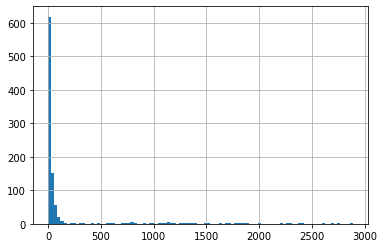

In [39]:
df_duration = (
    df
    .groupby(['match_id', 'attackerslot', 'cluster_30'])
    .agg({
        'time': ['first', 'last']
    })
)
df_duration['duration'] = df_duration[('time', 'last')] - df_duration[('time', 'first')]
display(df_duration.describe())
df_duration['duration'].hist(bins=100)

In [52]:
df[(
    (df['match_id'] == 6079386505) &
    (df['attackerslot'] == 1) &
    (df['cluster_30'] == 8) &
    # (df['type'] == 'DOTA_COMBATLOG_ABILITY') &
    True
)].groupby('type').count()

,time,value,attackername,targetname,sourcename,targetsourcename,attackerhero,targethero,attackerillusion,targetillusion,...,secondary_charges,tracked_death,tracked_sourcename,hero_name,attackerslot,clock,ones,cluster_10,cluster_20,cluster_30
type,,,,,,,,,,,,,,,,,,,,,
DOTA_COMBATLOG_ABILITY,28,28,28,28,28,28,28,28,28,28,...,0,0,0,0,28,28,28,0,0,28
DOTA_COMBATLOG_DAMAGE,205,205,205,205,205,205,205,205,205,205,...,0,0,0,0,205,205,205,109,109,205
DOTA_COMBATLOG_DEATH,11,11,11,11,11,11,11,11,11,11,...,0,0,0,0,11,11,11,0,0,11
DOTA_COMBATLOG_HEAL,171,171,171,171,171,171,171,171,171,171,...,0,0,0,0,171,171,171,0,0,171
DOTA_COMBATLOG_ITEM,13,13,13,13,13,13,13,13,13,13,...,0,0,0,0,13,13,13,0,0,13
DOTA_COMBATLOG_KILLSTREAK,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
DOTA_COMBATLOG_MODIFIER_ADD,36,36,36,36,36,36,36,36,36,36,...,0,0,0,0,36,36,36,0,0,36
DOTA_COMBATLOG_MODIFIER_REMOVE,33,33,33,33,33,33,33,33,33,33,...,0,0,0,0,33,33,33,0,0,33
DOTA_COMBATLOG_PLAYERSTATS,12,12,12,12,12,12,12,12,12,12,...,0,0,0,0,12,12,12,0,0,12


In [47]:
df[(
    (df['match_id'] == 6079386505) &
    (df['attackerslot'] == 1) &
    (df['cluster_30'] == 1) &
    (df['type'] == 'DOTA_COMBATLOG_ABILITY') &
    True
)].groupby('inflictor').count()

,time,type,value,attackername,targetname,sourcename,targetsourcename,attackerhero,targethero,attackerillusion,...,secondary_charges,tracked_death,tracked_sourcename,hero_name,attackerslot,clock,ones,cluster_10,cluster_20,cluster_30
inflictor,,,,,,,,,,,,,,,,,,,,,
leshrac_diabolic_edict,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
leshrac_lightning_storm,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
leshrac_pulse_nova,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1


In [48]:
df[(
    (df['match_id'] == 6079386505) &
    (df['attackerslot'] == 1) &
    (df['cluster_30'] == 4) &
    (df['type'] == 'DOTA_COMBATLOG_DEATH') &
    True
)].count()['time']

5

### Урон в секунду

In [51]:
df_cand = (
    df[
        (df['type'] == 'DOTA_COMBATLOG_DAMAGE') &
        (df['time'] > 10 * 60) &
        (df['attackerhero'] & df['targethero']) &
        (df['cluster_30'] > -1) &
        (df['match_id'] == 6079386505)
    ]
    .groupby(['match_id', 'attackerslot', 'cluster_30'])
    .agg({
        'value': 'sum', 
        'clock': ['first', 'last'],
        'time': ['first', 'last'],
    })
)

df_cand['duration'] = df_cand[('time', 'last')] - df_cand[('time', 'first')]
df_cand['damage_per_time'] = df_cand[('value', 'sum')] / df_cand['duration']

(
    df_cand[(
        (df_cand['duration'] > 5)
        
    )]
    .sort_values('damage_per_time', ascending=False)
    .head(20)
)

value  clock         time        \
                                        sum  first   last first  last   
match_id   attackerslot cluster_30                                      
6079386505 6.0          9.0         11587.0  34:39  34:55  2079  2095   
                        3.0          4645.0  18:27  18:36  1107  1116   
           5.0          7.0          1944.0  27:44  27:50  1664  1670   
           7.0          5.0          4714.0  28:11  28:28  1691  1708   
           8.0          2.0          1867.0  22:41  22:48  1361  1368   
           2.0          0.0          4731.0  30:12  30:30  1812  1830   
           6.0          8.0         18274.0  32:36  33:50  1956  2030   
                        2.0          1404.0  13:25  13:31   805   811   
           5.0          6.0          2017.0  24:22  24:31  1462  1471   
           6.0          6.0         13025.0  28:51  29:53  1731  1793   
           0.0          1.0          3136.0  18:29  18:44  1109  1124   
           6.0          10.0        10108.0  35:46  36:51  2146  2211   
           1.0          4.0          3108.0  18:16  18:36  1096  1116   
           8.0          3.0          2113.0  24:10  24:24  1450  1464   
           6.0          7.0          6223.0  31:17  32:04  1877  1924   
           3.0          2.0          2148.0  24:13  24:32  1453  1472   
           1.0          2.0          1982.0  13:20  13:38   800   818   
           0.0          2.0          1456.0  24:12  24:26  1452  1466   
           7.0          7.0          3298.0  33:30  34:03  2010  2043   
           0.0          7.0          2330.0  36:26  36:50  2186  2210   

                                   duration damage_per_time  
                                                             
match_id   attackerslot cluster_30                           
6079386505 6.0          9.0              16      724.187500  
                        3.0               9      516.111111  
           5.0          7.0               6      324.000000  
           7.0          5.0              17      277.294118  
           8.0          2.0               7      266.714286  
           2.0          0.0              18      262.833333  
           6.0          8.0              74      246.945946  
                        2.0               6      234.000000  
           5.0          6.0               9      224.111111  
           6.0          6.0              62      210.080645  
           0.0          1.0              15      209.066667  
           6.0          10.0             65      155.507692  
           1.0          4.0              20      155.400000  
           8.0          3.0              14      150.928571  
           6.0          7.0              47      132.404255  
           3.0          2.0              19      113.052632  
           1.0          2.0              18      110.111111  
           0.0          2.0              14      104.000000  
           7.0          7.0              33       99.939394  
           0.0          7.0              24       97.083333

### Фраги в секунду

In [44]:
df['match_id'].unique()

array([6227492909, 6079386505, 6214179880, 6215346651, 6216526891,
       6215020578, 6227203516, 6216545156, 6216665747, 6066863360])

In [50]:
df_cand = (
    df[
        (df['type'] == 'DOTA_COMBATLOG_DEATH') &
        (df['time'] > 10 * 60) &
        (df['attackerhero'] & df['targethero']) &
        (df['cluster_30'] > -1) &
        (df['match_id'] == 6079386505)
    ]
    .groupby(['match_id', 'attackerslot', 'cluster_30'])
    .agg({
        'value': 'count', 
        'clock': ['first', 'last'],
        'time': ['first', 'last'],
    })
)

df_cand['duration'] = df_cand[('time', 'last')] - df_cand[('time', 'first')]
df_cand['value_per_time'] = df_cand[('value', 'count')] / df_cand['duration']

# display(df_cand)
(
    df_cand[(
        (df_cand['duration'] > 0)
    )]
    .sort_values('value_per_time', ascending=False)
    .head(20)
)

value  clock         time       duration  \
                                   count  first   last first  last            
match_id   attackerslot cluster_30                                            
6079386505 0.0          1.0            2  18:34  18:38  1114  1118        4   
           7.0          6.0            2  29:10  29:15  1750  1755        5   
           3.0          2.0            2  24:23  24:32  1463  1472        9   
           0.0          5.0            3  33:25  33:57  2005  2037       32   
                        3.0            2  29:54  30:16  1794  1816       22   
           3.0          4.0            2  36:07  36:31  2167  2191       24   

                                   value_per_time  
                                                   
match_id   attackerslot cluster_30                 
6079386505 0.0          1.0              0.500000  
           7.0          6.0              0.400000  
           3.0          2.0              0.222222  
           0.0          5.0              0.093750  
                        3.0              0.090909  
           3.0          4.0              0.083333

- Продолжительность момента
- Урон по хайлайтам
- Использованные способности
- Кол-во целей-героев

Основные выводы:

- Зачастую хайлайт начинается в момент, когда героя уже убили
- В результате работы метода можем получать хайлайты длины 0 секунд